In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
import tensorflow as tf
from utils import get_gpu_name, get_number_processors, get_gpu_memory, get_cuda_version

print("OS: ", sys.platform)
print("Python: ", sys.version)
print("Keras: ", keras.__version__)
print("Tensorflow: ", tf.__version__)
print("Numpy: ", np.__version__)
print("Number of CPU processors: ", get_number_processors())
print("GPU: ", get_gpu_name())
print("GPU memory: ", get_gpu_memory())
#print("CUDA: ", get_cuda_version())

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.
/Users/miguel/anaconda3/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


OS:  darwin
Python:  3.5.4 |Anaconda, Inc.| (default, Nov  8 2017, 18:11:28) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Keras:  2.1.5
Tensorflow:  1.5.0
Numpy:  1.14.1
Number of CPU processors:  8
[Errno 2] No such file or directory: 'nvidia-smi'
GPU:  None
[Errno 2] No such file or directory: 'nvidia-smi'
GPU memory:  None


In [2]:
DATA = os.path.join('data', 'MSFT_2012_2017.csv')


In [3]:
df = pd.read_csv(DATA)
df = df.drop(['Adj Close', 'Volume'], axis=1)
#df = df.reindex(index = df.index[::-1])
df.head()


,Date,Open,High,Low,Close
0,2012-01-03,26.549999,26.959999,26.389999,26.770000
1,2012-01-04,26.820000,27.469999,26.780001,27.400000
2,2012-01-05,27.379999,27.730000,27.290001,27.680000
3,2012-01-06,27.530001,28.190001,27.530001,28.110001
4,2012-01-09,28.049999,28.100000,27.719999,27.740000


In [4]:
open_price = df[['Open']]
mean_price = df.mean(axis = 1)



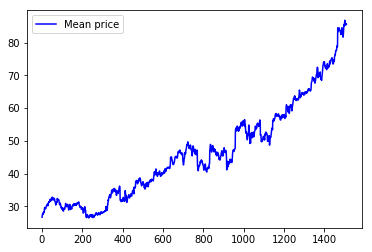

In [5]:
xx = np.arange(1, len(df) + 1, 1)
plt.plot(xx, mean_price, 'b', label = 'Mean price')
#plt.plot(xx, open_price, 'r', label = 'Open price')
plt.legend(loc = 'upper left')
plt.show()

In [6]:
mean_price = np.reshape(mean_price.values, (len(mean_price),1)) 
scaler = MinMaxScaler(feature_range=(0, 1))
mean_price = scaler.fit_transform(mean_price)

In [7]:

perc_cut = 0.30
train, test = train_test_split(mean_price, test_size=perc_cut, shuffle=False)
print(train.shape)
print(test.shape)

(1056, 1)
(453, 1)


In [8]:
def to_1dimension(df, step_size):
    data_X, data_Y = [], []
    for i in range(len(df)-step_size-1):
        a = df[i:(i+step_size), 0]
        data_X.append(a)
        data_Y.append(df[i + step_size, 0])
    return np.array(data_X), np.array(data_Y)

In [9]:
time_ahead = 5
X_train, y_train = to_1dimension(train, time_ahead)
X_test, y_test = to_1dimension(test, time_ahead)

In [10]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))


In [11]:
#BiLSTM
model = Sequential()
model.add(LSTM(30, input_shape=(1, time_ahead), return_sequences = True))
model.add(LSTM(20))
model.add(Dense(1))
model.add(Activation('linear'))

In [12]:
model.compile(loss='mean_squared_error', optimizer='adam') 
model.fit(X_train, y_train, epochs=5, batch_size=1, verbose=2)

Epoch 1/5
 - 4s - loss: 0.0029
Epoch 2/5
 - 3s - loss: 2.4785e-04
Epoch 3/5
 - 3s - loss: 2.1893e-04
Epoch 4/5
 - 3s - loss: 2.1517e-04
Epoch 5/5
 - 4s - loss: 2.0412e-04


In [13]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

pred_train = scaler.inverse_transform(pred_train)
y_train = scaler.inverse_transform([y_train])
pred_test = scaler.inverse_transform(pred_test)
y_test = scaler.inverse_transform([y_test])

score = math.sqrt(mean_squared_error(y_test[0], pred_test[:,0]))
print('Test RMSE: %.2f' % (score))

Test RMSE: 2.00


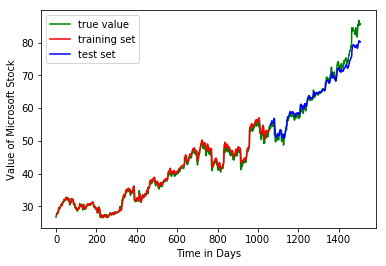

In [14]:
pred_trainPlot = np.empty_like(mean_price)
pred_trainPlot[:, :] = np.nan
pred_trainPlot[time_ahead:len(pred_train)+time_ahead, :] = pred_train

pred_testPlot = np.empty_like(mean_price)
pred_testPlot[:, :] = np.nan
pred_testPlot[len(pred_train)+(time_ahead*2)+1:len(mean_price)-1, :] = pred_test

mean_price = scaler.inverse_transform(mean_price)

plt.plot(mean_price, 'g', label = 'true value')
plt.plot(pred_trainPlot, 'r', label = 'training set')
plt.plot(pred_testPlot, 'b', label = 'test set')
plt.legend(loc = 'upper left')
plt.xlabel('Time in Days')
plt.ylabel('Value of Microsoft Stock')
plt.show()